# Classic Supervised Examples in Flax

This notebook is based on Flax's official [Annoted MNIST](https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html)
and [MNIST Example](https://github.com/google/flax/tree/main/examples/mnist).

But has been written to be a slightly more general Supervised Classification example. 
Primarily for educational purposes and reusability in other examples.

A really nice thing about this example is the use of the TrainState-object. We are able to bundle many necessary variables and functions with this object and can simply pass that around to our different functions. 

## Imports

Import JAX, [JAX NumPy](https://jax.readthedocs.io/en/latest/jax.numpy.html),
Flax, ordinary NumPy, and TensorFlow Datasets (TFDS). Flax can use any
data-loading pipeline and this example demonstrates how to utilize TFDS.

In [1]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow_datasets as tfds     # TFDS for MNIST
from ipywidgets import IntProgress

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
jax.devices()

## 1. Dataset - California Housing Regression problem

In [116]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from jax import numpy as jnp

def to_jax(data):
    return jnp.array(data, dtype=jnp.float32)

def get_datasets():
    """Load breast cancer train and test datasets into memory."""
    X, y = datasets.fetch_california_housing(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # Normalize
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    
    train_ds = {'X' : to_jax(X_train), 'y' : to_jax(y_train)}
    test_ds = {'X' : to_jax(X_test), 'y' : to_jax(y_test)}
    return train_ds, test_ds

In [117]:
train_ds, test_ds = get_datasets()

In [126]:
test_ds['X'].shape

(4128, 8)


## 2. Define network

Create a simple MLP neural network with the Linen API by subclassing
[`Module`](https://flax.readthedocs.io/en/latest/flax.linen.html#core-module-abstraction).

Here, two implementaions are provided: 
1. Using the [`@compact`](https://flax.readthedocs.io/en/latest/flax.linen.html#compact-methods) decorator. This is a very neat and "Keras"-like way of writing it.
2. Without `@compact`. Now you have to implement the `setup`-method, but it gives you more flexibility.

In [127]:
from typing import Sequence

class MLPRegressor(nn.Module):
    """A simple MLP model"""
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=16)(x)
        x = nn.relu(x)
        x = nn.Dense(features=8)(x)
        x = nn.relu(x)
        x = nn.Dense(features=4)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

In [128]:
class MLPRegressor(nn.Module):
    dimensions: Sequence[int]

    def setup(self):
        self.layers = [nn.Dense(d) for d in self.dimensions]

    def __call__(self, inputs):
        x = inputs
        for i, l in enumerate(self.layers):
            x = l(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x

## 3. Creating training state
This makes it much easier in traing as you only need to pass around the TrainState object in training and inference.

Because this is such a common pattern, Flax provides the class
[flax.training.train_state.TrainState](https://flax.readthedocs.io/en/latest/flax.training.html#train-state)
that serves most basic usecases. Usually one would subclass it to add more data
to be tracked, but in this example we can use it without any modifications.

In [129]:
def create_train_state(model, rng, learning_rate, momentum, sample):
    params = model.init(rng, jnp.ones(np.shape([sample])))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

Simple help-function for visualization

In [130]:
def visualize_layers(params):
    for layer_params in params.items():
        print("Layer Name : {}".format(layer_params[0]))
        weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]
        print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

## 4. Define a predict method
Since the output of the model is a sigmoid, it is already a probability. No need for softmax layers like we had with MNIST.

In [131]:
@jax.jit
def predict(state, X):
    y_pred = state.apply_fn({'params' : state.params}, X)
    return y_pred

## 5. Define a loss function and evaluation function
We use classic negative log loss

In [132]:
def neg_log_loss(preds, labels):
    preds = preds.squeeze()
    return (-labels * jnp.log(preds) - (1 - labels) * jnp.log(1 - preds)).mean()

In [133]:
def mse_loss(preds, labels):
    return jnp.power(labels - preds.squeeze(), 2).mean()

I tried with  

```[0 if pred < 0.5 else 1 for pred in preds] ``` 

first but it turns out JAX needs to know the sizes of all arrays at compilation time. Therefore,  ```jnp.where() ``` was used.

https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [134]:
def compute_metrics(*, preds, labels):
    loss = mse_loss(preds=preds, labels=labels)
    accuracy = jnp.mean(jnp.where(preds < .5, 0, 1).squeeze() == labels)
    metrics = {
        'loss': loss
    }
    return metrics

In [135]:
@jax.jit
def eval_step(state, X, y):
    preds = predict(state, X)
    return compute_metrics(preds=preds, labels=y)

Maybe include loss function in the training state? Would make the compute_metrics-function more general.

## 6. Training step

A function that:

- Evaluates the neural network given the parameters and a batch of input images
  with the
  [`Module.apply`](https://flax.readthedocs.io/en/latest/flax.linen.html#flax.linen.Module.apply)
  method.
- Computes the `neg_log_loss` loss function.
- Evaluates the loss function and its gradient using
  [`jax.value_and_grad`](https://jax.readthedocs.io/en/latest/jax.html#jax.value_and_grad).
- Applies a
  [pytree](https://jax.readthedocs.io/en/latest/pytrees.html#pytrees-and-jax-functions)
  of gradients to the optimizer to update the model's parameters.
- Computes the metrics using `compute_metrics` (defined earlier).

Use JAX's [`@jit`](https://jax.readthedocs.io/en/latest/jax.html#jax.jit)
decorator to trace the entire `train_step` function and just-in-time compile
it with [XLA](https://www.tensorflow.org/xla) into fused device operations
that run faster and more efficiently on hardware accelerators.

In [136]:
@jax.jit
def train_step(state, X, y):
    """Train for a single step."""
    def loss_fn(params):
        preds = state.apply_fn({'params' : params}, X)
        loss = mse_loss(preds=preds, labels=y)
        return loss, preds
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, preds), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(preds=preds, labels=y)
    return state, metrics

## 7. Train function

Define a training function that:

- Shuffles the training data before each epoch using
  [`jax.random.permutation`](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.permutation.html)
  that takes a PRNGKey as a parameter (check the
  [JAX - the sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#JAX-PRNG)).
- Runs an optimization step for each batch.
- Retrieves the training metrics from the device with `jax.device_get` and
  computes their mean across each batch in an epoch.
- Returns the optimizer with updated parameters and the training loss and
  accuracy metrics.

In [137]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['X'])
    steps_per_epoch = train_ds_size // batch_size
    
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size)) # perms are indices 
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm] for k, v in train_ds.items()} # v[perm, ...] ? 
        
        # This updates the state!
        state, metrics = train_step(state, X=batch['X'], y=batch['y'])
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] 
                        for metrics in batch_metrics_np])
                        for k in batch_metrics_np[0]}

    return state

## 8. Eval function

Create a model evaluation function that:

- Retrieves the evaluation metrics from the device with `jax.device_get`.
- Copies the metrics
  [data stored](https://flax.readthedocs.io/en/latest/design_notes/linen_design_principles.html#how-are-parameters-represented-and-how-do-we-handle-general-differentiable-algorithms-that-update-stateful-variables)
  in a JAX
  [pytree](https://jax.readthedocs.io/en/latest/pytrees.html#pytrees-and-jax-functions).

In [138]:
def eval_model(state, X, y):
    metrics = eval_step(state, X, y)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss']

## 9. Initialize the model

In [145]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
model = MLPRegressor([16,8,4,1])
sample = train_ds['X'][0]
learning_rate = 0.0001
momentum = 0.9
num_epochs = 100
batch_size = 128

# Create Training State
state = create_train_state(model, rng, learning_rate, momentum, sample)
#del seed

# Visualize layers
visualize_layers(state.params)

Layer Name : layers_0
	Layer Weights : (8, 16), Biases : (16,)
Layer Name : layers_1
	Layer Weights : (16, 8), Biases : (8,)
Layer Name : layers_2
	Layer Weights : (8, 4), Biases : (4,)
Layer Name : layers_3
	Layer Weights : (4, 1), Biases : (1,)


In [146]:
X_train = train_ds['X']
y_train = train_ds['y']

In [147]:
state = train_epoch(state, train_ds, batch_size, epoch=1, rng=rng)

In [148]:
y_pred = predict(state, X_train)

In [149]:
mse_loss(y_pred, y_train)

DeviceArray(4.0555077, dtype=float32)

## 10. Train and evaluate

Once the training and testing is done after 10 epochs, the output should show that your model was able to achieve approximately 99% accuracy.

In [150]:
history = {'loss' : [], 'val_loss' : [], 'epochs' : []}

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch 
    loss = eval_model(state, X=train_ds['X'], y=train_ds['y'])
    val_loss = eval_model(state, X=test_ds['X'], y=test_ds['y'])
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['epochs'].append(epoch)
    if epoch < 10:
        print('epoch: {}   | loss: {:.5f} | val_loss: {:.5f} |'.format(epoch, loss, val_loss))
    elif epoch < 100:
        print('epoch: {}  | loss: {:.5f} | val_loss: {:.5f} |'.format(epoch, loss, val_loss))
    else:
        print('epoch: {} | loss: {:.5f} | val_loss: {:.5f} |'.format(epoch, loss, val_loss))

epoch: 1   | loss: 2.82406 | val_loss: 2.74745 |
epoch: 2   | loss: 2.12478 | val_loss: 2.06187 |
epoch: 3   | loss: 1.73974 | val_loss: 1.68698 |
epoch: 4   | loss: 1.53397 | val_loss: 1.48911 |
epoch: 5   | loss: 1.42925 | val_loss: 1.38987 |
epoch: 6   | loss: 1.37640 | val_loss: 1.34094 |
epoch: 7   | loss: 1.34821 | val_loss: 1.31531 |
epoch: 8   | loss: 1.32991 | val_loss: 1.29884 |
epoch: 9   | loss: 1.31678 | val_loss: 1.28694 |
epoch: 10  | loss: 1.30540 | val_loss: 1.27628 |
epoch: 11  | loss: 1.29500 | val_loss: 1.26629 |
epoch: 12  | loss: 1.28469 | val_loss: 1.25616 |
epoch: 13  | loss: 1.27379 | val_loss: 1.24536 |
epoch: 14  | loss: 1.26187 | val_loss: 1.23351 |
epoch: 15  | loss: 1.24857 | val_loss: 1.22025 |
epoch: 16  | loss: 1.23355 | val_loss: 1.20516 |
epoch: 17  | loss: 1.21642 | val_loss: 1.18787 |
epoch: 18  | loss: 1.19654 | val_loss: 1.16778 |
epoch: 19  | loss: 1.17271 | val_loss: 1.14378 |
epoch: 20  | loss: 1.14334 | val_loss: 1.11401 |
epoch: 21  | loss: 1

In [151]:
state.apply_fn

<bound method Module.apply of MLPRegressor(
    # attributes
    dimensions = [16, 8, 4, 1]
)>

In [152]:
# apply_fn was defined above to be CNN().apply()
print(state.__dict__.keys())

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state'])


In [153]:
y_test = test_ds['y']

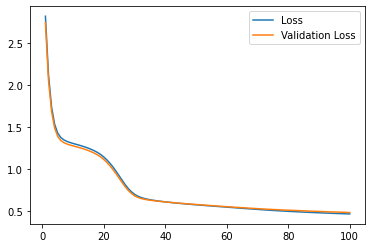

In [154]:
import matplotlib.pyplot as plt
plt.plot(history['epochs'], history['loss'], label='Loss')
plt.plot(history['epochs'], history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()